In [66]:
pip install seaborn nltk pandas wordcloud

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\gusta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB




In [68]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [69]:
#Importing and Visualizing the Data

df = pd.read_csv(r'C:\Users\gusta\Downloads\Teste_dhauz\Travel_Chalenge\Travel_Chalenge.csv',delimiter=';')
df.head()


,Airline Name,Overall_Rating,Review_Title,Review Date,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity
0,Air Seychelles,8,Air Seychelles customer review,10th April 2011,LHR-SEZ-LHR. It's true that there aren't perso...,NaN,NaN,Economy Class,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CityJet,1,CityJet customer review,10th April 2011,London City to Antwerp was delayed 3 hours 40 ...,NaN,NaN,Economy Class,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Shanghai Airlines,9,Shanghai Airlines customer review,10th April 2012,PEK to HGH in Economy. Slight delay out of PEK...,NaN,NaN,Economy Class,NaN,NaN,3.0,4.0,4.0,NaN,2.0,NaN
3,Aerolineas Argentinas,8,Aerolineas Argentinas customer review,10th April 2014,Rio to Buenos Aires AEP on 737. Departure dela...,NaN,NaN,Economy Class,NaN,NaN,3.0,4.0,0.0,NaN,0.0,NaN
4,Adria Airways,7,Adria Airways customer review,10th April 2015,Outbound flight FRA/PRN A319. 2 hours 10 min f...,NaN,NaN,Economy Class,NaN,NaN,4.0,4.0,4.0,NaN,0.0,NaN


### 1. Faça uma etapa de processamento dos dados para verificar possíveis dados faltantes ou duplicados

In [70]:
# 1. Verificar dimensões
print("\n🔢 Dimensões do dataset:")
print(f"Linhas: {df.shape[0]}, Colunas: {df.shape[1]}")

# 2. Verificar dados faltantes
print("\n🕳️ Verificando dados faltantes:")
missing = df.isnull().sum()
print(missing[missing > 0])  # Mostra apenas colunas com valores ausentes

# 3. Verificar porcentagem de dados faltantes
print("\n📊 Porcentagem de dados faltantes por coluna:")
percent_missing = df.isnull().mean() * 100
print(percent_missing[percent_missing > 0].sort_values(ascending=False))

# 4. Verificar e remover duplicatas
print("\n📎 Verificando duplicatas:")
duplicates = df.duplicated().sum()
print(f"Número de linhas duplicadas: {duplicates}")

if duplicates > 0:
    df = df.drop_duplicates()
    print(f"✅ {duplicates} duplicatas removidas.")
else:
    print("🚫 Nenhuma duplicata encontrada.")

# 5. Exibir linhas duplicadas
if duplicates > 0:
    print("\n🔁 Linhas duplicadas (primeiras 5):")
    print(df[df.duplicated()].head())

# 8. Informações gerais do dataset
print("\n🧠 Informações do DataFrame:")
print(df.info())


🔢 Dimensões do dataset:
Linhas: 17702, Colunas: 16

🕳️ Verificando dados faltantes:
Aircraft                  12037
Type Of Traveller          1749
Seat Type                   241
Route                      1826
Date Flown                 1758
Seat Comfort               2246
Cabin Staff Service        2336
Food & Beverages           5778
Ground Service             2646
Inflight Entertainment     8471
Wifi & Connectivity       12459
dtype: int64

📊 Porcentagem de dados faltantes por coluna:
Wifi & Connectivity       70.381878
Aircraft                  67.997966
Inflight Entertainment    47.853350
Food & Beverages          32.640380
Ground Service            14.947464
Cabin Staff Service       13.196249
Seat Comfort              12.687832
Route                     10.315219
Date Flown                 9.931081
Type Of Traveller          9.880240
Seat Type                  1.361428
dtype: float64

📎 Verificando duplicatas:
Número de linhas duplicadas: 29
✅ 29 duplicatas removidas.

🔁 Linh

### 2. Realize as etapas padrões de NLP nas colunas Review e Review_title (ex: Tokenização, remoção de stop-words, ...) 

In [71]:
# Inicializar ferramentas do NLTK
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Função de pré-processamento de texto
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()  # minúsculas
    text = re.sub(r'[^a-z\s]', '', text)  # remover pontuação e números
    tokens = word_tokenize(text)  # tokenização
    tokens = [t for t in tokens if t not in stop_words]  # remover stopwords
    tokens = [lemmatizer.lemmatize(t) for t in tokens]  # lematização
    return " ".join(tokens)

# Aplicar a função nas colunas de texto
df['Review_clean'] = df['Review'].apply(preprocess_text)
df['Review_Title_clean'] = df['Review_Title'].apply(preprocess_text)

# Visualizar resultado
display(df[['Review', 'Review_clean']].head(3))
display(df[['Review_Title', 'Review_Title_clean']].head(3))

,Review,Review_clean
0,LHR-SEZ-LHR. It's true that there aren't perso...,lhrsezlhr true arent personal tv like virgin b...
1,London City to Antwerp was delayed 3 hours 40 ...,london city antwerp delayed hour min sure whet...
2,PEK to HGH in Economy. Slight delay out of PEK...,pek hgh economy slight delay pek otherwise une...


,Review_Title,Review_Title_clean
0,Air Seychelles customer review,air seychelles customer review
1,CityJet customer review,cityjet customer review
2,Shanghai Airlines customer review,shanghai airline customer review


## 3. Exploração dos dados:

### A. Faça um gráfico para verificar a distribuição da feature Overall_rating pelas companhias aéreas. Faça um gráfico similar para verificar a distribuição dessa features pelos modelos de aeronaves (Aircraft) 


In [74]:
# Verificando os valores únicos de Overall_Rating
print(df['Overall_Rating'].unique())

# Verificando se há valores nulos
print(df['Overall_Rating'].isnull().sum())

['8' '1' '9' '7' '2' '3' '6' '5' '4' 'n']
0


In [73]:
# Excluindo ou substituindo valores nulos
df = df.dropna(subset=['Overall_Rating'])

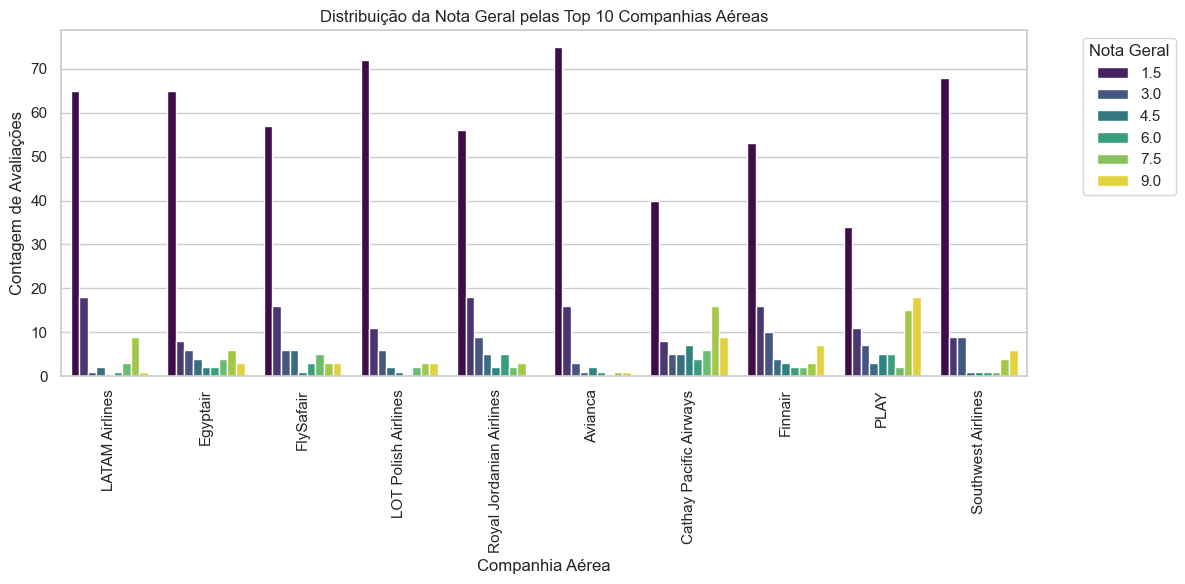

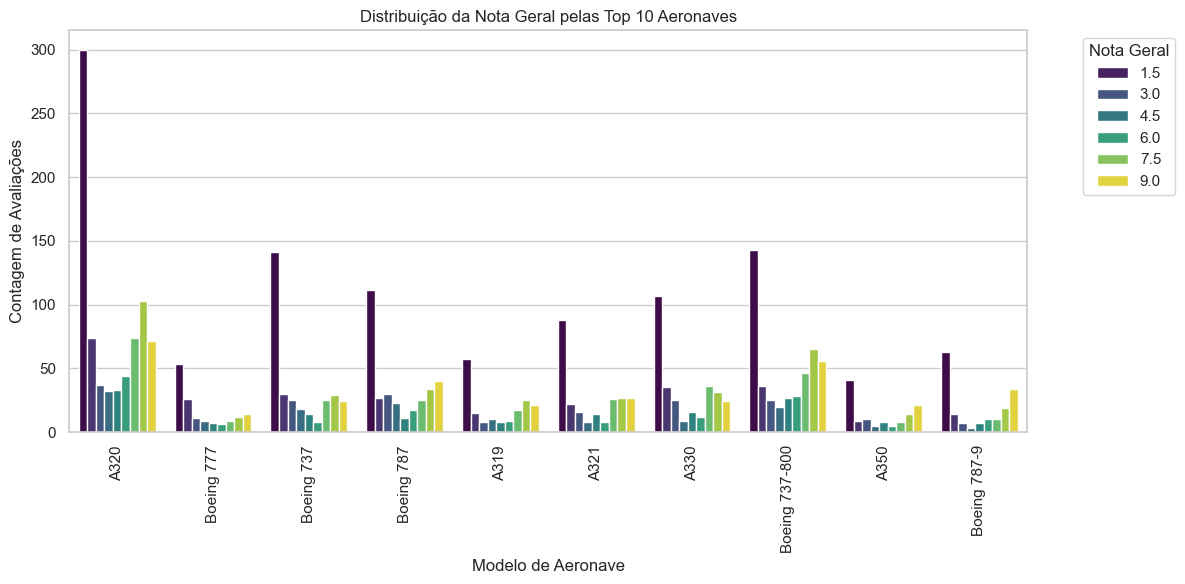

In [75]:
#a.
import seaborn as sns
import matplotlib.pyplot as plt

# Garantir que Overall_Rating seja numérico
df['Overall_Rating'] = pd.to_numeric(df['Overall_Rating'], errors='coerce')

# Ordenar as notas de Overall_Rating para exibir de forma crescente
df_sorted = df.sort_values('Overall_Rating', ascending=False)

# Definindo o número de companhias aéreas ou aeronaves a serem exibidas (top 10)
top_airlines = df['Airline Name'].value_counts().nlargest(10).index
top_aircrafts = df['Aircraft'].value_counts().nlargest(10).index

# Filtrar apenas as top 10 companhias aéreas
filtered_df_airlines = df[df['Airline Name'].isin(top_airlines)]

# Filtrar apenas as top 10 aeronaves
filtered_df_aircrafts = df[df['Aircraft'].isin(top_aircrafts)]

# Gráfico para a distribuição da nota geral (agrupada por nota inteira) pelas top 10 companhias aéreas
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_df_airlines, x='Airline Name', hue='Overall_Rating', palette='viridis')
plt.xticks(rotation=90)
plt.title('Distribuição da Nota Geral pelas Top 10 Companhias Aéreas')
plt.xlabel('Companhia Aérea')
plt.ylabel('Contagem de Avaliações')
plt.legend(title='Nota Geral', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Gráfico para aeronaves
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_df_aircrafts, x='Aircraft', hue='Overall_Rating', palette='viridis')
plt.xticks(rotation=90)
plt.title('Distribuição da Nota Geral pelas Top 10 Aeronaves')
plt.xlabel('Modelo de Aeronave')
plt.ylabel('Contagem de Avaliações')
plt.legend(title='Nota Geral', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()






Top 10 Companhias com maiores e menores médias

In [77]:
# Calcular média e contagem por companhia aérea
airline_stats = (
    df_rating_clean.groupby('Airline Name')['Overall_Rating']
    .agg(['mean', 'count'])
    .rename(columns={'mean': 'Average_Rating', 'count': 'Review_Count'})
    .sort_values(by='Average_Rating', ascending=False)
)

print("🎖️ Top 10 companhias com maiores médias:")
print(airline_stats.head(10).round(2))

print("\n⚠️ Top 10 companhias com menores médias:")
print(
    airline_stats.sort_values(by='Average_Rating', ascending=True)
    .head(10)
    .round(2)
)



🎖️ Top 10 companhias com maiores médias:
                         Average_Rating  Review_Count
Airline Name                                         
China Southern Airlines            6.31           100
QantasLink                         6.02            99
Lao Airlines                       5.74            72
Dragonair                          5.71            95
Royal Brunei Airlines              5.52           100
SilkAir                            5.20           100
Bulgaria Air                       5.18            95
BA CityFlyer                       5.13            71
Luxair                             5.06            53
Croatia Airlines                   5.00            86

⚠️ Top 10 companhias com menores médias:
                   Average_Rating  Review_Count
Airline Name                                   
Frontier Airlines            1.23           100
Spirit Airlines              1.26           100
Volaris                      1.27           100
Interjet                     

C:\Users\gusta\AppData\Local\Temp\ipykernel_14052\1777589788.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x='Average_Rating', y=top10_best_airlines.index, data=top10_best_airlines, palette='Blues_d')


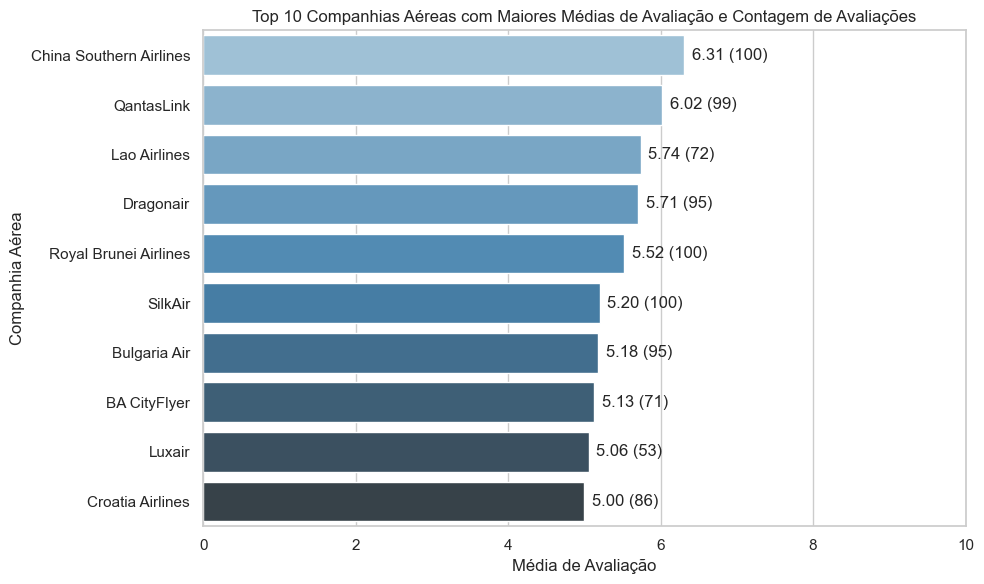

C:\Users\gusta\AppData\Local\Temp\ipykernel_14052\1777589788.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x='Average_Rating', y=top10_worst_airlines.index, data=top10_worst_airlines, palette='Reds')


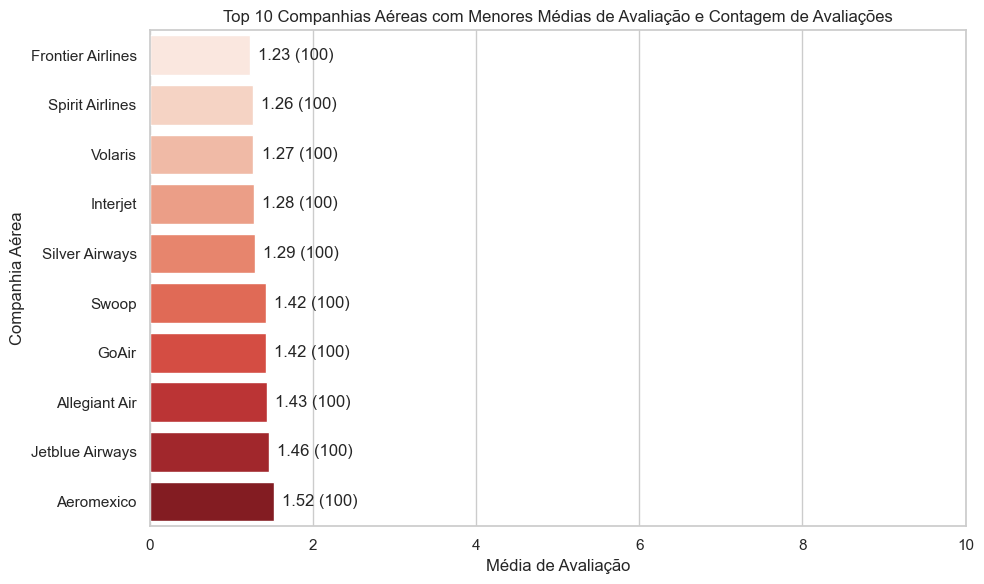

In [81]:
# Calcular média e contagem por companhia aérea
airline_stats = (
    df_rating_clean.groupby('Airline Name')['Overall_Rating']
    .agg(['mean', 'count'])
    .rename(columns={'mean': 'Average_Rating', 'count': 'Review_Count'})
    .sort_values(by='Average_Rating', ascending=False)
)

# 📊 Gráfico: Top 10 melhores companhias aéreas
top10_best_airlines = airline_stats.head(10)
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(x='Average_Rating', y=top10_best_airlines.index, data=top10_best_airlines, palette='Blues_d')
plt.title('Top 10 Companhias Aéreas com Maiores Médias de Avaliação e Contagem de Avaliações')
plt.xlabel('Média de Avaliação')
plt.ylabel('Companhia Aérea')
plt.xlim(0, 10)

# Adicionar rótulos com as notas
for i, (rating, count) in enumerate(zip(top10_best_airlines['Average_Rating'], top10_best_airlines['Review_Count'])):
    ax1.text(rating + 0.1, i, f'{rating:.2f} ({count})', va='center')

plt.tight_layout()
plt.show()

# 📉 Gráfico: Top 10 piores companhias aéreas
top10_worst_airlines = airline_stats.tail(10).sort_values(by='Average_Rating')
plt.figure(figsize=(10, 6))
ax2 = sns.barplot(x='Average_Rating', y=top10_worst_airlines.index, data=top10_worst_airlines, palette='Reds')
plt.title('Top 10 Companhias Aéreas com Menores Médias de Avaliação e Contagem de Avaliações')
plt.xlabel('Média de Avaliação')
plt.ylabel('Companhia Aérea')
plt.xlim(0, 10)

# Adicionar rótulos com as notas
for i, (rating, count) in enumerate(zip(top10_worst_airlines['Average_Rating'], top10_worst_airlines['Review_Count'])):
    ax2.text(rating + 0.1, i, f'{rating:.2f} ({count})', va='center')

plt.tight_layout()
plt.show()


Top 10 Aeronaves com maiores e menores médias com no mínimo 11 avaliações

In [82]:
# Calcular média e contagem por modelo de aeronave
avg_rating_aircraft = (
    df_rating_clean.groupby('Aircraft')['Overall_Rating']
    .agg(['mean', 'count'])
    .rename(columns={'mean': 'Average_Rating', 'count': 'Review_Count'})
)

# Filtrar aeronaves com mais de 10 avaliações
avg_rating_aircraft = avg_rating_aircraft[avg_rating_aircraft['Review_Count'] > 10]

# Ordenar pelas maiores médias
avg_rating_aircraft_sorted = avg_rating_aircraft.sort_values(by='Average_Rating', ascending=False)

print("🎖️ Top 10 aeronaves com maiores médias (mín. 11 avaliações):")
print(avg_rating_aircraft_sorted.head(10).round(2))

print("\n⚠️ Top 10 aeronaves com menores médias (mín. 11 avaliações):")
print(avg_rating_aircraft_sorted.tail(10).sort_values(by='Average_Rating').round(2))


🎖️ Top 10 aeronaves com maiores médias (mín. 11 avaliações):
                  Average_Rating  Review_Count
Aircraft                                      
A333                        6.15            13
Boeing 717                  5.86            14
E190                        5.82            34
E195                        5.79            14
A321-200                    5.67            15
Boeing 737 800              5.47            19
Boeing 737-900ER            5.40            20
A320Neo                     5.29            21
A330-300                    5.22           120
A320neo                     5.16            19

⚠️ Top 10 aeronaves com menores médias (mín. 11 avaliações):
                   Average_Rating  Review_Count
Aircraft                                       
Boeing 777-300-ER            1.50            16
Boeing 747                   1.72            18
Airbus                       2.09            11
Q400                         2.64            14
Boeing 737-900           

C:\Users\gusta\AppData\Local\Temp\ipykernel_14052\4136543842.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x='Average_Rating', y=top10_best.index, data=top10_best, palette='Blues_d')


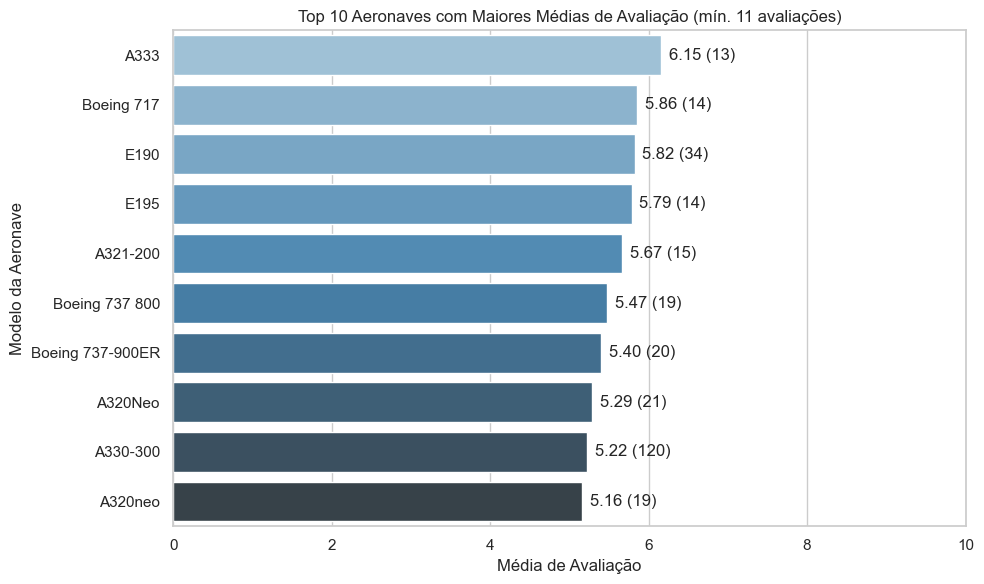

C:\Users\gusta\AppData\Local\Temp\ipykernel_14052\4136543842.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x='Average_Rating', y=top10_worst.index, data=top10_worst, palette='Reds')


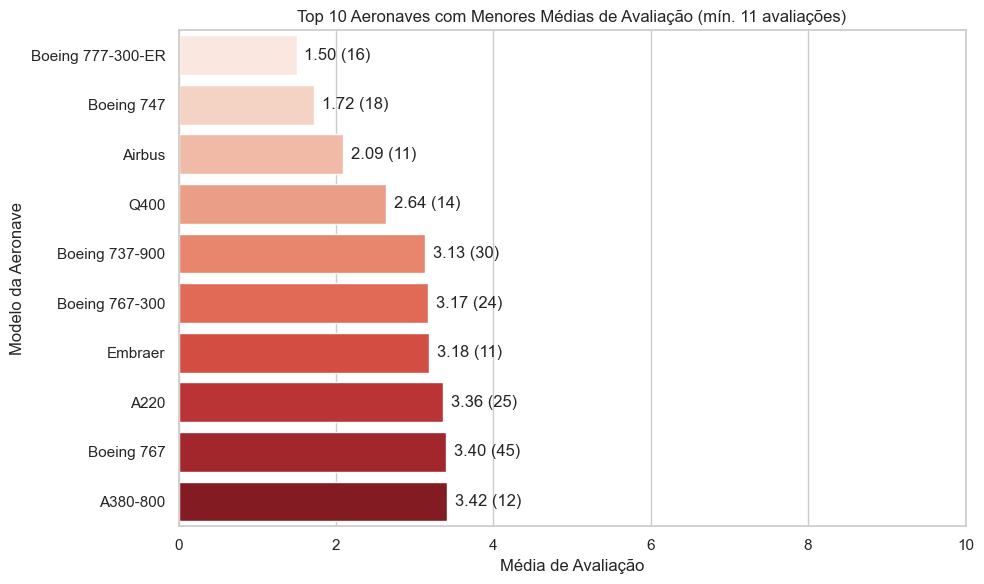

In [85]:
# Estilo limpo
sns.set(style='whitegrid')

# Dados
top10_best = avg_rating_aircraft_sorted.head(10)
top10_worst = avg_rating_aircraft_sorted.tail(10).sort_values(by='Average_Rating')

# 📊 Gráfico: Top 10 melhores aeronaves
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(x='Average_Rating', y=top10_best.index, data=top10_best, palette='Blues_d')
plt.title('Top 10 Aeronaves com Maiores Médias de Avaliação (mín. 11 avaliações)')
plt.xlabel('Média de Avaliação')
plt.ylabel('Modelo da Aeronave')
plt.xlim(0, 10)

# Adicionar rótulos com as notas
for i, (rating, count) in enumerate(zip(top10_best['Average_Rating'], top10_best['Review_Count'])):
    ax1.text(rating + 0.1, i, f'{rating:.2f} ({count})', va='center')

plt.tight_layout()
plt.show()

# 📉 Gráfico: Top 10 piores aeronaves
plt.figure(figsize=(10, 6))
ax2 = sns.barplot(x='Average_Rating', y=top10_worst.index, data=top10_worst, palette='Reds')
plt.title('Top 10 Aeronaves com Menores Médias de Avaliação (mín. 11 avaliações)')
plt.xlabel('Média de Avaliação')
plt.ylabel('Modelo da Aeronave')
plt.xlim(0, 10)

# Adicionar rótulos com as notas
for i, (rating, count) in enumerate(zip(top10_worst['Average_Rating'], top10_worst['Review_Count'])):
    ax2.text(rating + 0.1, i, f'{rating:.2f} ({count})', va='center')

plt.tight_layout()
plt.show()


### B. Utilize a visualização de nuvem de palavras para estudar quais palavras mais aparecem quando o Overall_rating é igual ou inferior a 3 e quando é igual ou superior a 8.

In [86]:
# Avaliações ruins (nota <= 3)
low_rating_reviews = df[df['Overall_Rating'] <= 3]['Review_clean'].dropna()
low_text = ' '.join(low_rating_reviews)

# Avaliações boas (nota >= 8)
high_rating_reviews = df[df['Overall_Rating'] >= 8]['Review_clean'].dropna()
high_text = ' '.join(high_rating_reviews)


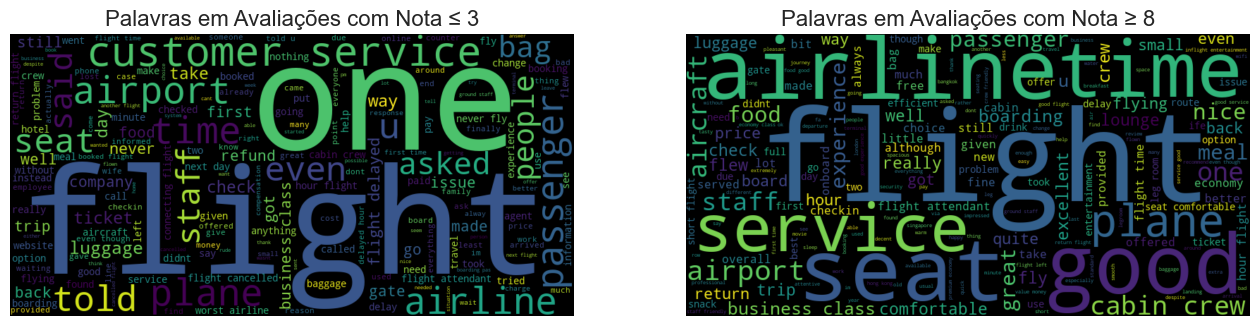

In [87]:
# Criar nuvem para avaliações ruins
wordcloud_low = WordCloud(width=800, height=400, background_color='black').generate(low_text)

# Criar nuvem para avaliações boas
wordcloud_high = WordCloud(width=800, height=400, background_color='black').generate(high_text)

# Exibir ambas lado a lado
plt.figure(figsize=(16, 8))

# Nuvem de palavras para notas baixas
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_low, interpolation='bilinear')
plt.title('Palavras em Avaliações com Nota ≤ 3', fontsize=16)
plt.axis('off')

# Nuvem de palavras para notas altas
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_high, interpolation='bilinear')
plt.title('Palavras em Avaliações com Nota ≥ 8', fontsize=16)
plt.axis('off')


plt.show()


### C. Estude a correlação e, portanto, o possível impacto das colunas que contém notas separadas ('Seat Comfort', 'Cabin StaƯ Service', 'Food & Beverages', 'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity') na nota final (Overall_rating) 


Overall_Rating            1.000000
Ground Service            0.545539
Cabin Staff Service       0.512995
Seat Comfort              0.500583
Food & Beverages          0.470263
Inflight Entertainment    0.418536
Wifi & Connectivity       0.374203
Name: Overall_Rating, dtype: float64


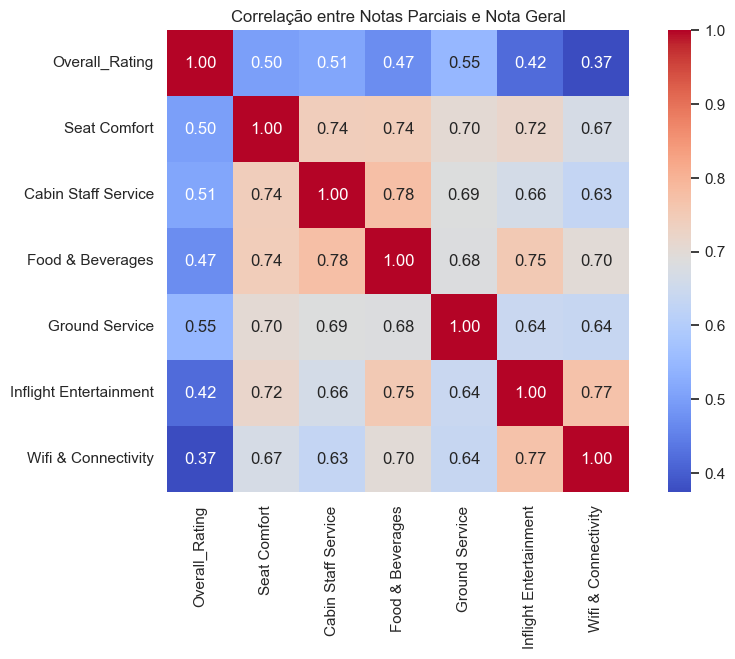

In [88]:
# Lista de colunas
rating_columns = [
    'Overall_Rating', 
    'Seat Comfort',
    'Cabin Staff Service',
    'Food & Beverages',
    'Ground Service',
    'Inflight Entertainment',
    'Wifi & Connectivity'
]

# Criar novo DataFrame só com essas colunas e remover linhas com valores ausentes
ratings_df = df[rating_columns].dropna()

# Correlação de Pearson
correlation_matrix = ratings_df.corr()
print(correlation_matrix['Overall_Rating'].sort_values(ascending=False))
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title('Correlação entre Notas Parciais e Nota Geral')
plt.show()



### 4. Utilizando o critério abaixo para classificar o sentimento de cada review como positivo, negativo e neutro, faça dois modelos de classificação de sentimentos, sendo um deles utilizando os textos da review e review_title como inputs e o outro utilizando as notas das features separadas ('Seat Comfort', 'Cabin StaƯ Service', 'Food & Beverages', 'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity') e compare os dois modelos. 

- a. Nota final menor que 4: Negativo 
- b. Nota final entre 4 e 7: Neutro 
- c. Nota final maior que 7: Positivo

Modelo 1 - Classificação de Sentimentos com Texto

In [90]:
def classify_sentiment(rating):
    if rating < 4:
        return 'negative'
    elif rating <= 7:
        return 'neutral'
    else:
        return 'positive'

df['Sentiment'] = df['Overall_Rating'].apply(classify_sentiment)

# Juntar as colunas textuais
df['Text_Combined'] = df['Review_Title_clean'] + ' ' + df['Review_clean']

tfidf = TfidfVectorizer(max_features=5000)
X_text = tfidf.fit_transform(df['Text_Combined'].fillna(''))


y = df['Sentiment']
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)


# Lista de modelos para comparar
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(random_state=42),
    'Naive Bayes': MultinomialNB()
}

# Treinar e avaliar cada modelo
for model_name, model in models.items():
    # Treinar o modelo
    model.fit(X_train_text, y_train)
    
    # Fazer as previsões
    y_pred = model.predict(X_test_text)
    
    # Imprimir o relatório de classificação para cada modelo
    print(f"📊 {model_name} Model:")
    print(classification_report(y_test, y_pred))
    print("-" * 60)


📊 Random Forest Model:
              precision    recall  f1-score   support

    negative       0.75      0.98      0.85      2464
     neutral       0.72      0.04      0.08       521
    positive       0.57      0.32      0.41       550

    accuracy                           0.74      3535
   macro avg       0.68      0.45      0.45      3535
weighted avg       0.72      0.74      0.67      3535

------------------------------------------------------------
📊 Logistic Regression Model:
              precision    recall  f1-score   support

    negative       0.82      0.93      0.87      2464
     neutral       0.51      0.24      0.33       521
    positive       0.54      0.48      0.51       550

    accuracy                           0.76      3535
   macro avg       0.62      0.55      0.57      3535
weighted avg       0.73      0.76      0.73      3535

------------------------------------------------------------
📊 SVM Model:
              precision    recall  f1-score   suppo

Modelo 2 - Classificação de Sentimentos com Notas Parciais

In [91]:
feature_cols = [
    'Seat Comfort', 'Cabin Staff Service', 'Food & Beverages',
    'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity'
]
df_num = df.dropna(subset=feature_cols + ['Sentiment'])

X_num = df_num[feature_cols]
y_num = df_num['Sentiment']


X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(X_num, y_num, test_size=0.2, random_state=42)


# Lista de modelos para comparar
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(random_state=42)
}

# Treinar e avaliar cada modelo com base nas notas parciais
for model_name, model in models.items():
    # Treinar o modelo
    model.fit(X_train_num, y_train_num)
    
    # Fazer as previsões
    y_pred = model.predict(X_test_num)
    
    # Imprimir o relatório de classificação para cada modelo
    print(f"🔢 {model_name} Model:")
    print(classification_report(y_test_num, y_pred))
    print("-" * 60)


🔢 Random Forest Model:
              precision    recall  f1-score   support

    negative       0.91      0.93      0.92       773
     neutral       0.51      0.39      0.44       104
    positive       0.54      0.58      0.56        77

    accuracy                           0.84       954
   macro avg       0.65      0.64      0.64       954
weighted avg       0.84      0.84      0.84       954

------------------------------------------------------------
🔢 Logistic Regression Model:
              precision    recall  f1-score   support

    negative       0.83      0.91      0.87       773
     neutral       0.43      0.03      0.05       104
    positive       0.29      0.39      0.33        77

    accuracy                           0.77       954
   macro avg       0.52      0.44      0.42       954
weighted avg       0.75      0.77      0.74       954

------------------------------------------------------------
🔢 SVM Model:
              precision    recall  f1-score   suppo

### Comparação geral entre os dois modelos:

O modelo baseado em texto tem um desempenho superior, especialmente no Random Forest e SVM, que se destacam pela precisão e recall nas classes negativas e neutras.

O modelo baseado nas notas parciais tem bom desempenho, mas sofre mais com a classe neutra e tem um recall mais baixo para a classe neutra.

### 5. Com o modelo de classificação de sentimentos, faça uma análise sobre o impacto de atrasos de viagem no NPS de 3 companhias aéreas. 
- a. NPS = %positivos-%negativos

In [92]:
# Função simples para identificar atrasos por palavras-chave
def detect_delay(text):
    delay_keywords = ['delay', 'delayed', 'late', 'hours', 'waiting', 'waited']
    text = str(text).lower()
    return any(word in text for word in delay_keywords)

df['Has_Delay'] = df['Review'].apply(detect_delay)

top_3_airlines = df['Airline Name'].value_counts().head(3).index.tolist()
df_top3 = df[df['Airline Name'].isin(top_3_airlines)]


def calculate_nps(subset):
    total = len(subset)
    if total == 0:
        return np.nan
    pct_positive = (subset['Sentiment'] == 'positive').sum() / total * 100
    pct_negative = (subset['Sentiment'] == 'negative').sum() / total * 100
    return pct_positive - pct_negative

# Agrupar os dados
nps_results = []

for airline in top_3_airlines:
    for delay_status in [True, False]:
        group = df_top3[(df_top3['Airline Name'] == airline) & (df_top3['Has_Delay'] == delay_status)]
        nps = calculate_nps(group)
        nps_results.append({
            'Airline': airline,
            'Has_Delay': delay_status,
            'NPS': nps,
            'Total Reviews': len(group)
        })

nps_df = pd.DataFrame(nps_results)

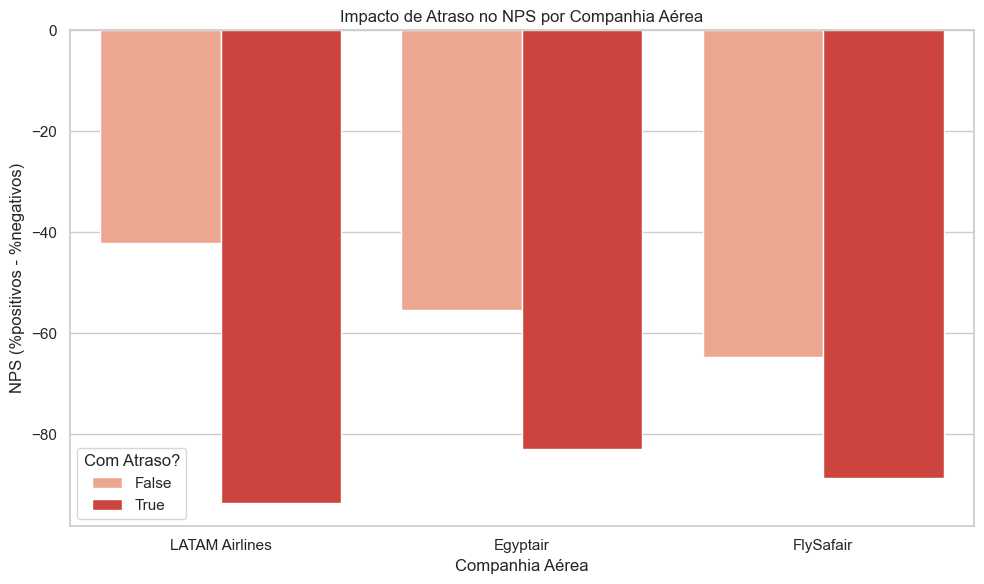

In [93]:
plt.figure(figsize=(10,6))
sns.barplot(data=nps_df, x='Airline', y='NPS', hue='Has_Delay', palette='Reds')
plt.title('Impacto de Atraso no NPS por Companhia Aérea')
plt.ylabel('NPS (%positivos - %negativos)')
plt.xlabel('Companhia Aérea')
plt.legend(title='Com Atraso?')
plt.tight_layout()
plt.show()
